In [1]:
!pip install smote_variants

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.7/184.7 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 70.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 47.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 63.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11705 sha256=2c85d5344fd7ee774d0176c824ec48af705f0556f4ee2364025fd1eecd167bf4

# Import Libraries

In [20]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, make_scorer, balanced_accuracy_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import smote_variants as sv
# import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline  

In [30]:
# Load the features dataset
df_features = pd.read_csv('/kaggle/input/skin-feature-dataset-multiclass/features_dataset_multiclass_full_v4.csv')
df_features_valid = pd.read_csv('/kaggle/input/skin-feature-dataset-multiclass/features_dataset_multiclass_valid_v4.csv')

# Separate features and labels
X = df_features.drop('label', axis=1)
y = df_features['label']

X_valid = df_features_valid.drop('label', axis=1)
y_valid = df_features_valid['label']

X_test = pd.read_csv('/kaggle/input/skin-feature-dataset-multiclass/features_dataset_multiclass_test_v4.csv')

In [31]:
print(df_features.shape)
print(df_features_valid.shape)
print(X_test.shape)

(5082, 843)
(1270, 843)
(2121, 842)


In [32]:
df_features['label'].value_counts()

label
mel    2713
bcc    1993
scc     376
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Manually set the classes in the order based on your dictionary
label_encoder.classes_ = np.array(['mel', 'bcc', 'scc'])

y_label = label_encoder.fit_transform(y)

In [7]:
print(y.head())
y_label[:5]

0    bcc
1    bcc
2    bcc
3    bcc
4    bcc
Name: label, dtype: object


array([0, 0, 0, 0, 0])

In [6]:
# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Utility functions for Preprocessing, Training and Evaluation

In [9]:
def apply_smote_undersample(X, y):
    """
    Apply SMOTE and undersampling to balance the classes in the training data.

    Parameters:
    - train_feat: Training features.
    - train_labels: Training labels.

    Returns:
    - train_feats: Resampled training features.
    - train_labels: Resampled training labels.
    """
    # Define the sampling strategy
    sampling_strategy = {0: np.sum(np.asarray(y) == 0), 
                         1: np.sum(np.asarray(y) == 1), 
                         2: 2713}

    # SMOTE Approach
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=24)
    under = RandomUnderSampler(sampling_strategy={0: 1694, 1: 1694, 2: 1694})
    steps = [('o', sm), ('u', under)]
    pipeline = Pipeline(steps=steps)

    # Sample the features:
    X_res, y_res = pipeline.fit_resample(X, y)
    return X_res, y_res


def preprocess_data(X, y, test_size=0.2, random_state=42, use_power_transformer=False, balance_data=False):
    """
    Preprocess the data by splitting, encoding, scaling, and balancing (optional).

    Parameters:
    - X: Features (input data).
    - y: Labels (target data).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generator.
    - use_power_transformer: Boolean, whether to apply PowerTransformer to make the data more Gaussian-like.
    - balance_data: Boolean, whether to apply SMOTE and undersampling to balance the data.

    Returns:
    - X_train_scaled, X_test_scaled: Scaled feature data for training and testing.
    - y_train_encoded, y_test_encoded: Encoded labels for training and testing.
    - label_mapping: The label encoding dictionary used for encoding/decoding class labels.
    - scaler: The scaler or transformer used for feature scaling.
    """

    # Define the label mapping dictionary
    label_mapping = {'mel': 0, 'bcc': 1, 'scc': 2}
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Encode the labels using the dictionary
    y_train_encoded = y_train.map(label_mapping)
    y_test_encoded = y_test.map(label_mapping)

    # Apply SMOTE and undersampling if balance_data is True
    if balance_data:
        X_train, y_train_encoded = apply_smote_undersample(X_train, y_train_encoded)
    
    # Apply scaling or PowerTransformer
    if use_power_transformer:
        transformer = PowerTransformer(method='yeo-johnson', standardize=True)
        X_train_scaled = transformer.fit_transform(X_train)
        X_test_scaled = transformer.transform(X_test)
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, label_mapping, transformer if use_power_transformer else scaler


def train_model(model, X_train_scaled, y_train_encoded, param_grid=None, cv=3, scoring='accuracy'):
    """
    Train the model with the training data, using GridSearchCV if a param_grid is provided.

    Parameters:
    - model: The machine learning model to train.
    - X_train_scaled: Scaled training features.
    - y_train_encoded: Encoded labels for the training set.
    - param_grid: Dictionary of hyperparameters to search in GridSearchCV.
    - cv: Number of cross-validation folds (default is 5).
    - scoring: Scoring metric for GridSearchCV (default is 'accuracy').

    Returns:
    - best_model: The trained model (best model if using GridSearchCV).
    - best_params: Best parameters found by GridSearchCV (None if param_grid is not provided).
    - train_accuracy: Accuracy of the best model on the training set.
    """
    
    # Check if param_grid is provided for hyperparameter tuning
    if param_grid:
        # Wrap the model with GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train_encoded)
        
        # Get the best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters: {best_params}")
    else:
        # If no param_grid is provided, fit the model directly
        model.fit(X_train_scaled, y_train_encoded)
        best_model = model
        best_params = None
    
    # Calculate training accuracy to check for overfitting
    y_train_pred = best_model.predict(X_train_scaled)
    train_accuracy = balanced_accuracy_score(y_train_encoded, y_train_pred)
    print(f"Training Balanced Accuracy of Best Model: {train_accuracy:.4f}")
    
    return best_model, best_params, train_accuracy


def evaluate_model(model, model_name, X_test_scaled, y_test_encoded, label_mapping):
    """
    Evaluate the trained model on the test data and display metrics.

    Parameters:
    - model: The trained machine learning model.
    - model_name: A string representing the model's name.
    - X_test_scaled: Scaled testing features.
    - y_test_encoded: Encoded labels for the testing set.
    - label_mapping: The label encoding dictionary used to decode class labels.

    Returns:
    - accuracy: The accuracy score of the model on the test set.
    - report: The classification report.
    - confusion: The confusion matrix.
    """
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Decode the predictions and true labels back to the original class labels
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    y_pred_decoded = pd.Series(y_pred).map(inverse_label_mapping)
    y_test_decoded = y_test_encoded.map(inverse_label_mapping)
    
    # Calculate metrics
    balanced_accuracy = balanced_accuracy_score(y_test_decoded, y_pred_decoded)
    report = classification_report(y_test_decoded, y_pred_decoded)
    confusion = confusion_matrix(y_test_decoded, y_pred_decoded)
    kappa_result = cohen_kappa_score(y_test_decoded, y_pred_decoded)
    
    # Display results
    print(f"Model: {model_name}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(confusion)
    print("Kappa Score")
    print(kappa_result)
    print("-" * 60)
    
    return balanced_accuracy, report, confusion, kappa_result

def train_and_evaluate_pipeline(model, model_name, X, y, test_size=0.2, random_state=42, use_power_transformer=False, param_grid=None, balance_data=False):
    """
    Complete pipeline for preprocessing, training, and evaluating a model with optional GridSearchCV.

    Parameters:
    - model: The machine learning model to train.
    - model_name: A string representing the model's name.
    - X: Features (input data).
    - y: Labels (target data).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generator.
    - use_power_transformer: Boolean, whether to apply PowerTransformer to make the data more Gaussian-like.
    - param_grid: Dictionary of hyperparameters for GridSearchCV (optional).
    - balance_data: Boolean, whether to apply SMOTE and undersampling to balance the training data.

    Returns:
    - accuracy, report, confusion, best_params, train_accuracy: Evaluation metrics and hyperparameters.
    """
    
    # Start measuring the execution time
    strt = time.time()
    
    # Step 1: Preprocess the data
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, label_encoder, transformer = preprocess_data(
        X, y, test_size, random_state, use_power_transformer=use_power_transformer, balance_data=balance_data
    )
    
    # Step 2: Train the model with GridSearchCV if param_grid is provided
    trained_model, best_params, train_accuracy = train_model(model, X_train_scaled, y_train_encoded, param_grid=param_grid)
    
    # Stop measuring the execution time
    end = time.time()
    print(f'Total Time for Training Model "{model_name}": {end - strt:.2f} seconds')
    
    # Step 3: Evaluate the model on the test set
    balanced_accuracy, report, confusion, kappa_result = evaluate_model(trained_model, model_name, X_test_scaled, y_test_encoded, label_encoder)
    
    # Print a comparison to check for overfitting
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {balanced_accuracy:.4f}")
    
    return balanced_accuracy, report, confusion, kappa_result, best_params


# Feature Selection using Random Forest

In [10]:
model = RandomForestClassifier(n_estimators=300,
                        max_depth=30,
                        min_samples_split=5,
                        min_samples_leaf=1,
                        random_state=42)

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="Random Forest",
    X=X,
    y=y,
    use_power_transformer=False,
    balance_data=False
)

Training Balanced Accuracy of Best Model: 0.9926
Total Time for Training Model "Random Forest": 8.58 seconds
Model: Random Forest
Balanced Accuracy: 0.6017
Classification Report:
              precision    recall  f1-score   support

         bcc       0.77      0.88      0.82       399
         mel       0.87      0.90      0.89       543
         scc       1.00      0.03      0.05        75

    accuracy                           0.83      1017
   macro avg       0.88      0.60      0.59      1017
weighted avg       0.84      0.83      0.80      1017

Confusion Matrix:
[[351  48   0]
 [ 55 488   0]
 [ 50  23   2]]
Kappa Score
0.6737639841212559
------------------------------------------------------------
Training Accuracy: 0.9926
Test Accuracy: 0.6017


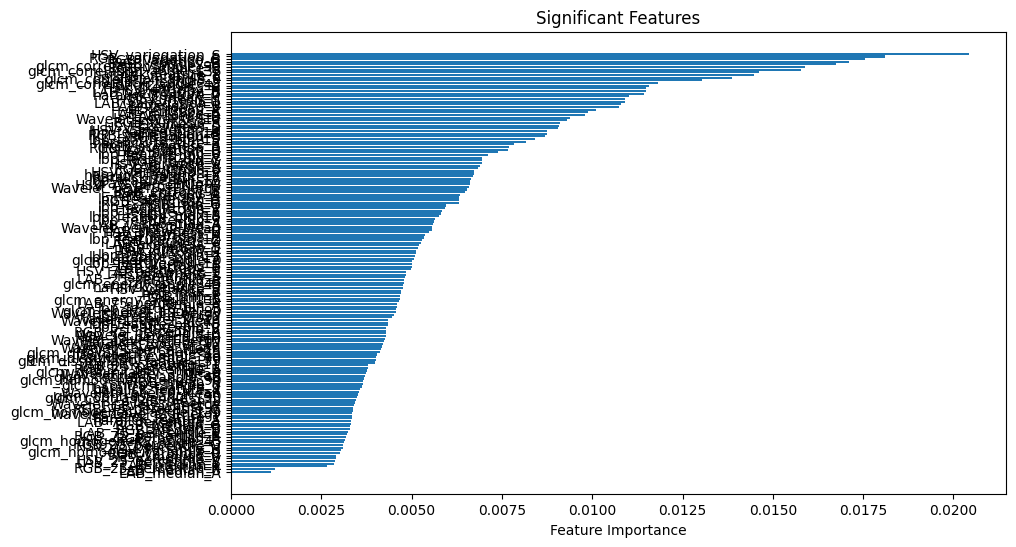

In [11]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Set a threshold for significance (e.g., keep features with importance > 0.02)
significant_features = feature_importances[feature_importances['Importance'] > 0.001]

# Sort features by importance
significant_features = significant_features.sort_values(by='Importance', ascending=False)

# Visualize feature significance
plt.figure(figsize=(10, 6))
plt.barh(significant_features['Feature'], significant_features['Importance'])
plt.xlabel("Feature Importance")
plt.title("Significant Features")
plt.gca().invert_yaxis()
plt.show()

In [12]:
selected_features = list(significant_features['Feature'])

In [33]:
df_feature_full = pd.concat([df_features, df_features_valid], axis=0)

# df_feature_selected = df_feature_full[selected_features]

# df_feature_selected.shape

In [34]:
# df = df_feature_selected.copy()
df = df_feature_full.copy()
# df['label'] = df_feature_full['label']
df.shape

(6352, 843)

In [35]:
df = df.sample(frac = 1).reset_index(drop=True)

df.head()

,RGB_min_R,RGB_max_R,RGB_kurtosis_R,RGB_min_G,RGB_max_G,RGB_kurtosis_G,RGB_min_B,RGB_max_B,RGB_kurtosis_B,HSV_min_H,...,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99,label
0,95.0,255.0,-1.115344,30.0,255.0,-1.458740,7.0,255.0,-1.526420,0.0,...,-2.537054e-31,2.599224e-31,-1.139153e-30,-7.736853e-31,3.649227e-31,-2.563205e-31,-5.350214e-31,-1.021903e-30,-5.281227e-31,mel
1,36.0,255.0,-0.844255,18.0,255.0,-1.419879,4.0,255.0,-1.562347,0.0,...,-2.031973e-30,-1.081685e-30,-1.322621e-30,-5.321793e-31,-1.379985e-30,2.842865e-31,-8.948085e-31,1.019726e-30,6.413772e-31,mel
2,49.0,255.0,15.122414,5.0,255.0,18.479825,4.0,255.0,17.308237,0.0,...,-2.031973e-30,-1.081685e-30,-1.322621e-30,-5.321793e-31,-1.379985e-30,2.842865e-31,-8.948085e-31,1.019726e-30,6.413772e-31,mel
3,57.0,255.0,-0.146989,9.0,255.0,0.035629,4.0,255.0,-0.149554,0.0,...,-2.031973e-30,-1.081685e-30,-1.322621e-30,-5.321793e-31,-1.379985e-30,2.842865e-31,-8.948085e-31,1.019726e-30,6.413772e-31,mel
4,17.0,255.0,-1.100614,1.0,255.0,-1.555272,0.0,255.0,-1.685381,0.0,...,-2.031973e-30,-1.081685e-30,-1.322621e-30,-5.321793e-31,-1.379985e-30,2.842865e-31,-8.948085e-31,1.019726e-30,6.413772e-31,mel


# Hyperparater tuning using GridSearchCV

In [36]:
X = df.drop('label', axis=1)
print(X.shape)
y = df['label']
y.shape

(6352, 842)


(6352,)

## Random Forest

In [ ]:
# # Initialize your model
# model = RandomForestClassifier()

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [70, 250, 2000],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [13, 20],
#     'min_samples_split': [8],
#     'max_features': [0.5780093202212182]
# }

# # Run the pipeline with PowerTransformer and GridSearchCV
# accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
#     model=model,
#     model_name="Random Forest with GridSearchCV",
#     X=X,
#     y=y,
#     use_power_transformer=False,
#     param_grid=param_grid
# )

# print("Best Parameters:", best_params)

In [37]:
# Initialize your model
model = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=20, min_samples_split=8, max_features=0.5780093202212182)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [70, 250, 2000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 20],
    'min_samples_split': [8],
    'max_features': [0.5780093202212182]
}

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="Random Forest with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    # param_grid=param_grid
)

print("Best Parameters:", best_params)

Training Balanced Accuracy of Best Model: 0.9592
Total Time for Training Model "Random Forest with GridSearchCV": 120.75 seconds
Model: Random Forest with GridSearchCV
Balanced Accuracy: 0.6121
Classification Report:
              precision    recall  f1-score   support

         bcc       0.76      0.87      0.81       498
         mel       0.87      0.88      0.88       679
         scc       0.62      0.09      0.15        94

    accuracy                           0.82      1271
   macro avg       0.75      0.61      0.61      1271
weighted avg       0.81      0.82      0.80      1271

Confusion Matrix:
[[432  61   5]
 [ 79 600   0]
 [ 59  27   8]]
Kappa Score
0.6598718499734131
------------------------------------------------------------
Training Accuracy: 0.9592
Test Accuracy: 0.6121
Best Parameters: None


## XGBoost

In [38]:
# Initialize your model
model = XGBClassifier(objective="multi:softmax", num_class=3, 
                        n_estimators=2000, 
                        max_depth=7, 
                        learning_rate=0.1)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.5],
    'n_estimators': [100, 300, 2000],
    'max_depth': [5, 7, 10],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'min_samples_split': [8, 10],
    'gamma': [0]
}

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="XGBoost with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    # param_grid=param_grid
)

print("Best Parameters:", best_params)

Training Balanced Accuracy of Best Model: 1.0000
Total Time for Training Model "XGBoost with GridSearchCV": 298.07 seconds
Model: XGBoost with GridSearchCV
Balanced Accuracy: 0.6622
Classification Report:
              precision    recall  f1-score   support

         bcc       0.80      0.88      0.84       498
         mel       0.89      0.90      0.90       679
         scc       0.59      0.20      0.30        94

    accuracy                           0.84      1271
   macro avg       0.76      0.66      0.68      1271
weighted avg       0.83      0.84      0.83      1271

Confusion Matrix:
[[439  50   9]
 [ 62 613   4]
 [ 48  27  19]]
Kappa Score
0.7079909617344096
------------------------------------------------------------
Training Accuracy: 1.0000
Test Accuracy: 0.6622
Best Parameters: None


## LightGBM

In [39]:
# Initialize your model
model = LGBMClassifier(random_state=42)

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="LightGBM",
    X=X,
    y=y,
    use_power_transformer=False,
)

print("Best Parameters:", best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40887
[LightGBM] [Info] Number of data points in the train set: 5081, number of used features: 259
[LightGBM] [Info] Start training from score -0.627822
[LightGBM] [Info] Start training from score -0.935867
[LightGBM] [Info] Start training from score -2.603674
Training Balanced Accuracy of Best Model: 0.9999
Total Time for Training Model "LightGBM": 9.79 seconds
Model: LightGBM
Balanced Accuracy: 0.6593
Classification Report:
              precision    recall  f1-score   support

         bcc       0.79      0.88      0.84       498
         mel       0.89      0.90      0.90       679
         scc       0.64      0.19      0.30        94

    accuracy                           0.84      1271
   macro avg       0.78      0.66      0.68

## Support Vector Machine

In [40]:
# Initialize your model
model = SVC()

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [4, 7, 11],
    'kernel': ['linear', 'rbf', 'poly'],
}

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="Support Vector Machine with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    param_grid=param_grid
)

print("Best Parameters:", best_params)

Best Parameters: {'C': 11, 'kernel': 'rbf'}
Training Balanced Accuracy of Best Model: 0.7481
Total Time for Training Model "Support Vector Machine with GridSearchCV": 37.63 seconds
Model: Support Vector Machine with GridSearchCV
Balanced Accuracy: 0.6404
Classification Report:
              precision    recall  f1-score   support

         bcc       0.77      0.89      0.82       498
         mel       0.89      0.89      0.89       679
         scc       0.58      0.15      0.24        94

    accuracy                           0.83      1271
   macro avg       0.75      0.64      0.65      1271
weighted avg       0.82      0.83      0.82      1271

Confusion Matrix:
[[441  48   9]
 [ 76 602   1]
 [ 55  25  14]]
Kappa Score
0.687364655794686
------------------------------------------------------------
Training Accuracy: 0.7481
Test Accuracy: 0.6404
Best Parameters: {'C': 11, 'kernel': 'rbf'}


# Stacking

In [42]:
# Initialize classifiers with the obtained best parameters
lr = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(max_depth=30,min_samples_leaf=1, min_samples_split=5,n_estimators=300)
xgb = XGBClassifier(learning_rate=0.5,n_estimators=300,max_depth=5,subsample=1.0,colsample_bytree=0.8,gamma=0)
lightgbm = LGBMClassifier(random_state=42)
svc = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 11)

In [43]:
# Create a list of classifiers with their respective names
classifiers = [('lr', lr), ('lightgbm', lightgbm), ('svc', svc), ('rf', rf), ('xgb', xgb)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=3)

# Run the pipeline with PowerTransformer and GridSearchCV
balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=stacking_clf,
    model_name="Boosting Ensemble",
    X=X,
    y=y,
    use_power_transformer=False,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40887
[LightGBM] [Info] Number of data points in the train set: 5081, number of used features: 259
[LightGBM] [Info] Start training from score -0.627822
[LightGBM] [Info] Start training from score -0.935867
[LightGBM] [Info] Start training from score -2.603674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39079
[LightGBM] [Info] Number of data points in the train set: 3387, number of used features: 259
[LightGBM] [Info] Start training from score -0.627723
[LightGBM] [Info] Start training from score -0.936271
[LightGBM] [Info] Start training from score -2.602247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016747 s

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Balanced Accuracy of Best Model: 0.9989
Total Time for Training Model "Boosting Ensemble": 329.99 seconds
Model: Boosting Ensemble
Balanced Accuracy: 0.6842
Classification Report:
              precision    recall  f1-score   support

         bcc       0.80      0.87      0.83       498
         mel       0.90      0.89      0.89       679
         scc       0.56      0.29      0.38        94

    accuracy                           0.84      1271
   macro avg       0.75      0.68      0.70      1271
weighted avg       0.83      0.84      0.83      1271

Confusion Matrix:
[[434  48  16]
 [ 67 607   5]
 [ 44  23  27]]
Kappa Score
0.7065222707661999
------------------------------------------------------------
Training Accuracy: 0.9989
Test Accuracy: 0.6842


# Voting

In [44]:
estimators = [('lgbm', lightgbm), ('xgb', xgb)]

# Create a VotingClassifier with the specified estimators and soft voting strategy
voter = VotingClassifier(estimators=estimators, voting='soft')

balanced_accuracy, report, confusion, kappa_result, best_params = train_and_evaluate_pipeline(
    model=voter,
    model_name="Voting Ensemble",
    X=X,
    y=y,
    use_power_transformer=False,
    balance_data=False
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40887
[LightGBM] [Info] Number of data points in the train set: 5081, number of used features: 259
[LightGBM] [Info] Start training from score -0.627822
[LightGBM] [Info] Start training from score -0.935867
[LightGBM] [Info] Start training from score -2.603674
Training Balanced Accuracy of Best Model: 1.0000
Total Time for Training Model "Voting Ensemble": 51.69 seconds
Model: Voting Ensemble
Balanced Accuracy: 0.6670
Classification Report:
              precision    recall  f1-score   support

         bcc       0.80      0.89      0.84       498
         mel       0.89      0.90      0.90       679
         scc       0.59      0.21      0.31        94

    accuracy                           0.85      1271
   macro avg       0.76      0.67      0.68      1271
weighted avg       0.83      0.85     

In [8]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
X_scaled = scaler.fit_transform(X)
X_valid_scaled = scaler.transform(X_valid)

In [9]:
noise_filter= sv.noise_removal.NeighborhoodCleaningRule()
X_samp, y_samp= noise_filter.remove_noise(X_scaled, y)

# rus = RandomUnderSampler(sampling_strategy={'mel': 1000, 'bcc': 1000, 'scc': 376}, random_state=42)
# X_samp, y_samp= rus.fit_resample(X_samp, y_samp)

2024-11-03 22:05:43,268:INFO:NeighborhoodCleaningRule: Running noise removal
2024-11-03 22:05:43,275:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-03 22:05:43,318:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


In [65]:
# oversampler= smote_variants.MulticlassOversampling(oversampler='distance_SMOTE', oversampler_params={})

# X_samp, y_samp= oversampler.sample(X_samp, y_samp)

In [66]:
# # Apply SMOTE and Tomek Links on the training data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [10]:
np.unique(y_samp, return_counts=True)

(array(['bcc', 'mel', 'scc'], dtype=object), array([1993, 2052,  376]))

In [23]:
# Initialize the models with increased max_iter for Logistic Regression
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Balanced Random Forest": BalancedRandomForestClassifier(
        n_estimators=100,
        random_state=42,
        sampling_strategy='auto', 
        replacement=True,          
        bootstrap=False),
    "Support Vector Machine": SVC(kernel='linear', random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(max_depth=30,min_samples_leaf=1, min_samples_split=5,n_estimators=300),
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_scaled, y)
    
    # Make predictions on the test set
    y_pred = model.predict(X_valid_scaled)
    
    # Evaluate the model with Cohen's Kappa Score
    kappa = cohen_kappa_score(y_valid, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Kappa Score: {kappa:.4f}")
    print("Classification Report:")
    print(classification_report(y_valid, y_pred, zero_division=0))  # Avoid warning by handling zero division
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid, y_pred))
    print("-" * 60)

NameError: name 'label_encoder' is not defined

In [14]:
X_selected = X[list(significant_features['Feature'])]
X_selected_valid = X_valid[(list(significant_features['Feature']))]

print(X_selected.shape)
X_selected_valid.shape

(5082, 157)


(1270, 157)

In [15]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected_valid_scaled = scaler.transform(X_selected_valid)

In [16]:
noise_filter= sv.noise_removal.NeighborhoodCleaningRule()
X_samp, y_samp= noise_filter.remove_noise(X_selected_scaled, y)

2024-11-03 22:08:43,549:INFO:NeighborhoodCleaningRule: Running noise removal
2024-11-03 22:08:43,557:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2024-11-03 22:08:43,568:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


In [17]:
np.unique(y_samp, return_counts=True)

(array(['bcc', 'mel', 'scc'], dtype=object), array([1993, 2065,  376]))

In [24]:
# Initialize the models
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300),
    "XGBoost " : xgb.XGBClassifier(objective="multi:softmax", num_class=3, 
                        n_estimators=2000, 
                        max_depth=7, 
                        learning_rate=0.1)

}


label_encoder = LabelEncoder()

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model

    y_encoded = label_encoder.fit_transform(y_samp)
    y_valid_encoded = label_encoder.transform(y_valid)
    
    model.fit(X_samp, y_encoded)
    
    # Make predictions on the test set
    y_pred = model.predict(X_selected_valid_scaled)

    # Decode the predictions and true labels back to the original class labels
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_valid_decoded = label_encoder.inverse_transform(y_valid_encoded)
    
    # Evaluate the model with Cohen's Kappa Score
    kappa = cohen_kappa_score(y_valid_decoded, y_pred_decoded)
    
    print(f"Model: {model_name}")
    print(f"Kappa Score: {kappa:.4f}")
    print("Classification Report:")
    print(classification_report(y_valid_decoded, y_pred_decoded, zero_division=0))  # Avoid warning by handling zero division
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid_decoded, y_pred_decoded))
    print("-" * 60)


# # Train and evaluate each model
# for model_name, model in models.items():
#     # Train the model
#     model.fit(X_samp, y_samp)
    
#     # Make predictions on the test set
#     y_pred = model.predict(X_selected_valid_scaled)
    
#     # Evaluate the model with Cohen's Kappa Score
#     kappa = cohen_kappa_score(y_valid, y_pred)
    
#     print(f"Model: {model_name}")
#     print(f"Kappa Score: {kappa:.4f}")
#     print("Classification Report:")
#     print(classification_report(y_valid, y_pred, zero_division=0))  # Avoid warning by handling zero division
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_valid, y_pred))
#     print("-" * 60)

Model: Logistic Regression
Kappa Score: 0.6282
Classification Report:
              precision    recall  f1-score   support

         bcc       0.71      0.91      0.80       498
         mel       0.91      0.81      0.85       678
         scc       0.32      0.11      0.16        94

    accuracy                           0.80      1270
   macro avg       0.65      0.61      0.60      1270
weighted avg       0.79      0.80      0.78      1270

Confusion Matrix:
[[455  31  12]
 [123 546   9]
 [ 60  24  10]]
------------------------------------------------------------
Model: Support Vector Machine
Kappa Score: 0.6282
Classification Report:
              precision    recall  f1-score   support

         bcc       0.70      0.93      0.80       498
         mel       0.92      0.81      0.86       678
         scc       0.17      0.02      0.04        94

    accuracy                           0.80      1270
   macro avg       0.60      0.59      0.57      1270
weighted avg       0.78  

## Oversampling

In [ ]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_samp_encoded = label_encoder.fit_transform(y_samp)

# Define custom scorer
kappa = make_scorer(cohen_kappa_score)

# Define the pipeline with scaling, hybrid sampling, and classifier
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('sampling', SMOTEENN()),  # Placeholder, actual method set in GridSearchCV
    ('classifier', XGBClassifier(objective="multi:softmax", num_class=3, 
                                 n_estimators=2000, 
                                 max_depth=7, 
                                 learning_rate=0.1))
])

# Define specific sampling strategies for hybrid methods
oversample_strategy_1 = {'mel': 2065, 'bcc': 1993, 'scc': 800}
oversample_strategy_2 = {'mel': 2065, 'bcc': 1993, 'scc': 1000}

# Update oversampling strategies with encoded labels
oversample_strategy_1_enc = {label_encoder.transform([k])[0]: v for k, v in oversample_strategy_1.items()}
oversample_strategy_2_enc = {label_encoder.transform([k])[0]: v for k, v in oversample_strategy_2.items()}

# Define parameter grid to test SMOTEENN and SMOTETomek with different sampling strategies
param_grid = {
    'sampling': [
        SMOTEENN(sampling_strategy=oversample_strategy_1_enc),
        SMOTEENN(sampling_strategy=oversample_strategy_2_enc),
        SMOTETomek(sampling_strategy=oversample_strategy_1_enc),
        SMOTETomek(sampling_strategy=oversample_strategy_2_enc)
    ]
}

# Set up GridSearchCV with the pipeline and parameter grid
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring=kappa
)

# Fit the pipeline with encoded labels
grid.fit(X_samp, y_samp_encoded)

# Print best parameters and score
print("Best parameters:", grid.best_params_)
print("Best kappa score:", grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [18]:
# Retrieve the best pipeline from the grid search
best_pipeline = grid.best_estimator_

# Fit the best pipeline to your entire dataset
best_pipeline.fit(X_samp, y_samp)

# Now you can make predictions with the trained model
y_pred = best_pipeline.predict(X_selected_valid_scaled)  # Replace X_test with your actual test data

# Optionally, evaluate the model on the test set
from sklearn.metrics import classification_report, cohen_kappa_score

print("Classification Report:")
print(classification_report(y_valid, y_pred))  # Replace y_test with your actual test labels
print("Cohen Kappa Score:", cohen_kappa_score(y_valid, y_pred))


Classification Report:
              precision    recall  f1-score   support

         bcc       0.70      0.91      0.79       498
         mel       0.91      0.78      0.84       678
         scc       0.52      0.23      0.32        94

    accuracy                           0.79      1270
   macro avg       0.71      0.64      0.65      1270
weighted avg       0.80      0.79      0.79      1270

Cohen Kappa Score: 0.6258211523467256


In [41]:
X = df_feature_full.drop('label', axis=1)
y = df_feature_full['label']

In [42]:
print(X.shape)
print(X_test.shape)
y.shape

(6352, 842)
(2121, 842)


(6352,)

In [43]:
# Define the label mapping dictionary
label_mapping = {'mel': 0, 'bcc': 1, 'scc': 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
# Encode the labels using the dictionary
y_encoded = y.map(label_mapping)

In [45]:
print(y.head())
print(y_encoded[:5])

0    bcc
1    bcc
2    bcc
3    bcc
4    bcc
Name: label, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64


## Predicting Test Set

In [46]:
rf = RandomForestClassifier(n_estimators=300,
                        max_depth=30,
                        min_samples_split=5,
                        min_samples_leaf=1,
                        random_state=42)

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

In [47]:
rf.fit(X_scaled, y_encoded)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=300,
                       random_state=42)

In [48]:
y_pred = rf.predict(X_scaled_test)

In [49]:
test_predict_df = pd.DataFrame(y_pred, columns=["Predicted_Label"])

In [51]:
test_predict_df.shape

(2121, 1)

In [52]:
test_predict_df.to_csv('test_prediction.csv', index=False)

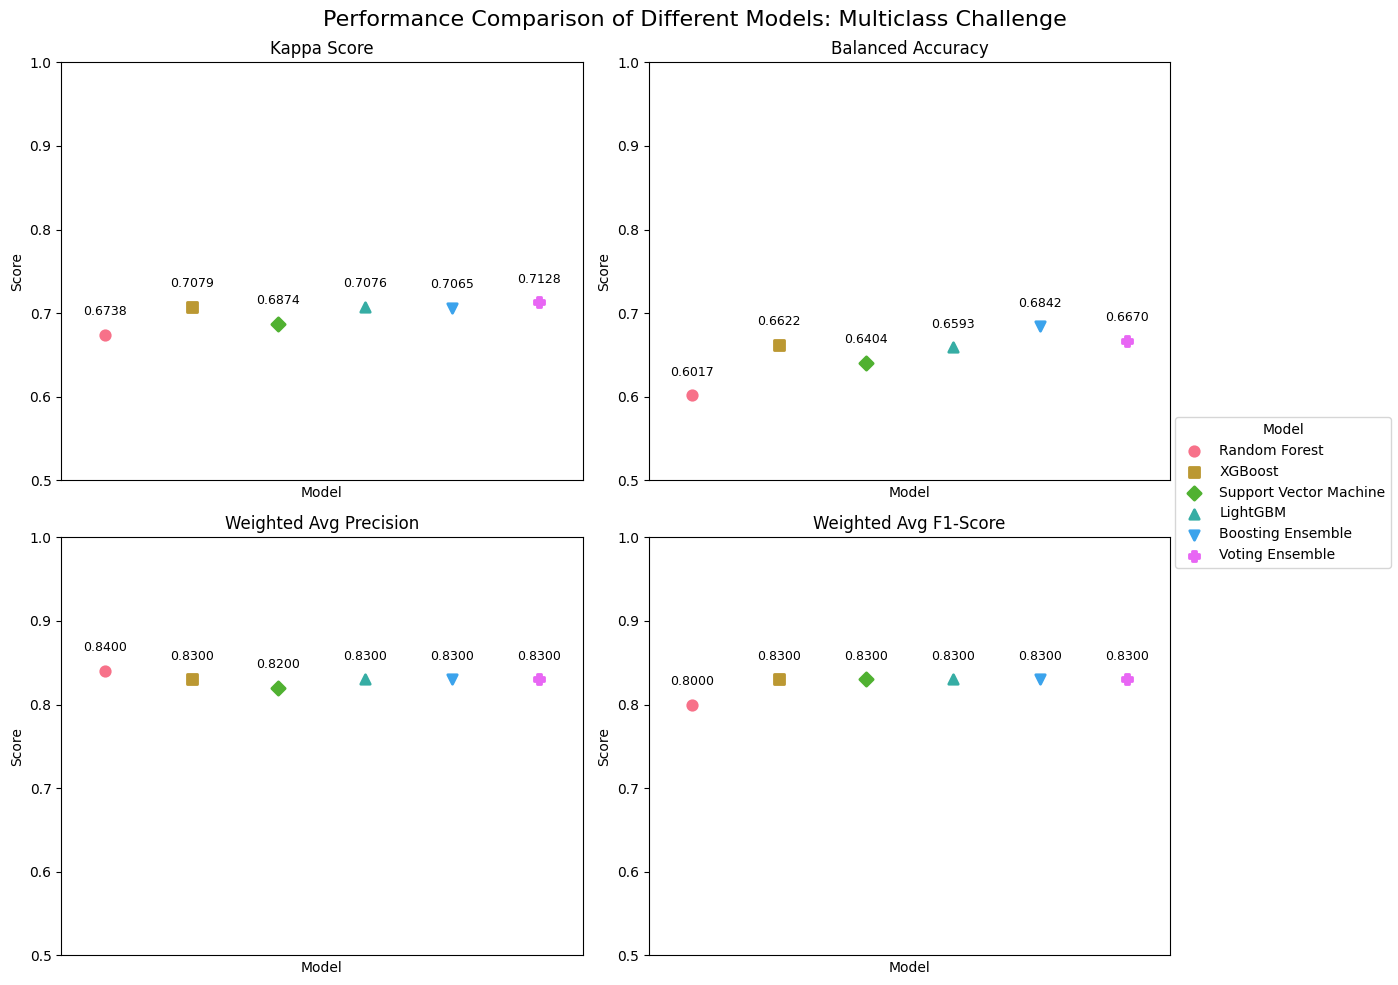

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the metrics for each model
models = [
    'Random Forest', 'XGBoost', 'Support Vector Machine', 
    'LightGBM', 'Boosting Ensemble', 'Voting Ensemble'
]
kappa_score = [0.6738, 0.7079, 0.6874, 0.7076, 0.7065, 0.7128]
balanced_accuracy = [0.6017, 0.6622, 0.6404, 0.6593, 0.6842, 0.6670]
weighted_avg_precision = [0.84, 0.83, 0.82, 0.83, 0.83, 0.83]
weighted_avg_f1_score = [0.80, 0.83, 0.83, 0.83, 0.83, 0.83]

# Prepare the data in a DataFrame for Seaborn
data = pd.DataFrame({
    'Model': models,
    'Kappa Score': kappa_score,
    'Balanced Accuracy': balanced_accuracy,
    'Weighted Avg Precision': weighted_avg_precision,
    'Weighted Avg F1-Score': weighted_avg_f1_score
})

# Melt the DataFrame for easy plotting
data_melted = data.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Comparison of Different Models: Multiclass Challenge', fontsize=16)

# Define markers and colors
markers = ['o', 's', 'D', '^', 'v', 'P']
palette = sns.color_palette("husl", len(models))

# Plot each metric in a different subplot without x-axis model names
for i, (metric, ax) in enumerate(zip(['Kappa Score', 'Balanced Accuracy', 'Weighted Avg Precision', 'Weighted Avg F1-Score'], axs.flat)):
    sns.pointplot(
        data=data_melted[data_melted['Metric'] == metric], 
        x='Model', y='Score', hue='Model', 
        ax=ax, markers=markers, palette=palette
    )
    ax.set_title(metric)
    ax.set_ylim(0.5, 1.0)
    ax.set_xticks([])  # Remove x-axis model names

    # Suppress the individual subplot legends
    ax.get_legend().remove()

    # Annotate each point with the exact score
    for j, model in enumerate(models):
        score = data[metric][j]
        ax.text(j, score + 0.02, f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Add a single legend on the right side
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Model')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend on the right
plt.show()
